# Deep Q-Networks (DQN)
*Note: This tutorial assumes that you have completed reading the policy gradient notebook and have an understanding of Markov Decision Processes and policy gradient models. If not, please revisit them [here](../PolicyGradient/policygradient_discrete.ipynb) and [here](../PolicyGradient/policygradient_continuous.ipynb).*

The goals of this notebook are to:
1. Explain what Deep Q-Networks are, and why we might want to use them.
2. Understand its mathematical foundations.
3. Explain potential issues with DQN.
4. Apply it to the Metadrive environment.

#### What's the relationship between Deep Q Networks and Deep Q Learning?

In this notebook, we throw around the terms "Deep Q Networks" as well as "Deep Q Learning" a lot. It's worthwhile to take a moment to understand the difference between the two.
* Q-Learning is a reinforcement learning algorithm that's based on learning the value of taking a particular action in a particular state. However, it doesn't require us to use a neural network. We could use a table to store the values of each state-action pair, and update them as we learn more about the environment, although this approach is only feasible for small environments.
* Deep Q-Learning is the exact same algorithm, except we use a neural network to represent the Q function. This allows us to scale Q-Learning to large environments, and generalize across similar states.  
* A Deep Q Network is the neural network that we use to represent the Q function when using the Deep Q-Learning algorithm. It takes in a state as input, and outputs the Q value for each action.

We'll cover all of these in more detail later.

## What is Q-Learning?

Just like in Policy Gradients, our goal is to find the optimal policy $\pi^*$ that maximizes the expected return $J(\pi)$. However, instead of directly learning the policy, we will try to learn the optimal action-value function $Q^*(s,a)$, which is the expected return of taking action $a$ in state $s$ and then following the optimal policy $\pi^*$.

Once we have a good estimate of $Q^*(s,a)$, we can find the optimal policy by simply taking the action with the highest $Q$ value in each state. This is known as the **greedy policy**.

#### Tic-Tac-Toe Example
Let's illustrate this with an example. Consider the game of Tic-Tac-Toe. The state of the game is the current board configuration, and the actions are the possible moves that the current player can make. The optimal action-value function $Q^*(s,a)$ tells us the expected return of taking action $a$ in state $s$ and then following the optimal policy $\pi^*$. You can think of it as a sort of "cheat sheet" that tells us whether it is possible for us to win the game if we take a particular action in a particular state, or if the position is a forced loss or draw.

If we have this cheat sheet, we can easily find the optimal policy. We simply choose actions which have the highest $Q$ value in each state. That is, we take the action that says we can force a win, if it exists. If not, we take the action that says we can force a draw, if it exists.

It's clear that using this approach, we'll never lose a game of Tic-Tac-Toe. This is the core idea behind Q-Learning.

## Why DQN?
In the last notebook, you learned about policy gradients - a way to create powerful learners that update on the gradient of the objective function itself.

However, they have a few key downsides that are addressed with DQN:
* **Sample inefficiency**: to accurately estimate the gradient via Monte-Carlo methods, the model needs to run over many episodes on the environment. Policy-gradient methods typically require many times more training samples than other methods. You probably observed that the REINFORCE algorithm took many episodes just to learn to consistently drive forwards on the Metadrive environment! While this is alleviated with more advanced algorithms like Proximal Policy Optimization (PPO) (which we'll explore later), , Deep-Q learning inherently bypasses the sample inefficiency of policy gradient methods. This is because Q-learning methods can take advantage of off-policy learning and replay buffers to continue to learn from its past mistakes, as the value of a state-action pair stays relatively constant as the agent learns (in the short term), making it feasible to have the same trajectory in the replay buffer for multiple epochs and update on it many times.

* **Exploration-exploitation trade-off**: To learn in any environment, an agent will need to explore (to sample from diverse environmental states) and exploit (focus on high-reward strategies). To improve at chess, we might play our best moves most of the time, but also throw in a few questionable moves to test them out and broaden our strategic choices. Policy gradient methods can get stuck in local optimal due to insufficient exploration. In Deep-Q learning, we explicitly set a parameter that sets the balance between exploration and exploitation.


## Understanding the Math

### $V(s)$ and $Q(s, a)$
As we dive into our exploration of Q-networks, it's useful to take a look at a key idea that will come up often later on: we can denote the *value* of a state (how good a position is) by denoting **value**, $V(s)$ and **quality**, $Q(s, a)$ functions. 

More specifically, the **value** function represents the value of a **state** while the **quality** function represents the quality of a **state-action pair**. OpenAI's [Spinning Up on Deep RL](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#trajectories) has a great article on this, which we'll reiterate below:

> There are four main functions of note:
>
>The On-Policy Value Function, $V^{\pi}(s)$, which gives the expected return if you start in state s and always act according to policy $\pi$:
>
>$$V^{\pi}(s) = \underset{\tau \sim \pi}{\operatorname{E}}[{R(\tau)\left| s_0 = s\right.}]$$
>
>The On-Policy Action-Value Function, $Q^{\pi}(s,a)$, which gives the expected return if you start in state s, take an arbitrary action a (which may not have come from the policy), and then forever after act according to policy $\pi$:
>
>$$Q^{\pi}(s,a) = \underset{\tau \sim \pi}{\operatorname{E}}[{R(\tau)\left| s_0 = s, a_0 = a\right.}]$$
>
>The Optimal Value Function, $V^*(s)$, which gives the expected return if you start in state s and always act according to the optimal policy in the environment:
>
>$$V^*(s) = \max_{\pi} \underset{\tau \sim \pi}{\operatorname{E}}[{R(\tau)\left| s_0 = s\right.}]$$
>
>The Optimal Action-Value Function, $Q^*(s,a)$, which gives the expected return if you start in state s, take an arbitrary action a, and then forever after act according to the optimal policy in the environment:
>
>$$Q^*(s,a) = \max_{\pi} \underset{\tau \sim \pi}{\operatorname{E}}[{R(\tau)\left| s_0 = s, a_0 = a\right.}]$$

An important note is that the value of a state or the quality of a state-action pair can be very different depending on our policy. For example, in chess, a mate-in-five position that's down on material would be of great value to a grandmaster but useless to a novice.

### Turning $Q(s, a)$ into $\pi(s, a)$

Given the quality function $Q^\pi(s_t, a_t)$, there are a variety of strategies we can use to select our actions. One is always taking the action that we believe has the highest quality:
$$
\pi(s_t, a_t) = \underset{a \in A}{\operatorname{argmax}} \space Q^\pi(s_t, a)
$$ 

If we've learned the optimal quality function $Q^*(s, a)$, then this works, but while we're training, we want a way to explore. Take a look at the following example:

Text(8, 16, 'end')

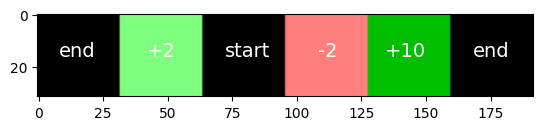

In [36]:
import matplotlib.pyplot as plt
import numpy as np
red, green, light_green, black = np.zeros((4, 32, 32, 3))
red += np.array([1, 0.5, 0.5])
green += np.array([0, 0.75, 0])
light_green += np.array([0.5,1,0.5])
plt.imshow(np.concatenate([black, light_green, black, red, green, black], axis=1))
plt.text(42, 16, '+2', color='white', fontsize=14)
plt.text(108, 16, '-2', color='white', fontsize=14)
plt.text(134, 16, '+10', color='white', fontsize=14)
plt.text(72, 16, 'start', color='white', fontsize=14)
plt.text(168, 16, 'end', color='white', fontsize=14)
plt.text(8, 16, 'end', color='white', fontsize=14)

Before we gather any samples about the environment, the model is equally likely to explore either the +2 square and the -2 square. Let's imagine it explores the +2 square before ending the episode; after updating at the end of the episode, the model learns to always seek out the +2 square, never being able to reach the +10 square (with each update afterward only confirming its bias). Clearly, we need to add a term for exploration:

### Epsilon-Greedy

We introduce a parameter epsilon ($\epsilon$) that controls the balance between exploration and exploitation. We can then define our policy as follows:

$$\pi(s) = \begin{cases}
\underset{a \in A}{\operatorname{argmax}} \space Q(s, a) & \text{with probability } 1 - \epsilon \\
\text{random action} & \text{with probability } \epsilon
\end{cases}$$

We set $\epsilon$ to a high value (~0.3) at the start of training and slowly reduce it as the model explores more strategies.
You can retrieve the greedy policy by setting $\epsilon$ to 0. 

### Learning $Q(s, a)$

It's clear that if we have a good estimate of $Q^*(s, a)$, we can find the optimal policy by simply taking the action with the highest $Q$ value in each state. However, how do we actually learn $Q^*(s, a)$?

It's simple:
1. We start off with a random neural network that takes in a state as input, and outputs the Q value for each action. We denote this neural network $Q_\phi(s, a)$, where $\phi$ represents the parameters of the neural network.
2. We collect a bunch of trajectories by running an epsilon-greedy policy on the environment.
3. For each state-action pair in each trajectory:
    * Our current estimate of $Q^*(s,a)$, $Q_{\phi}(s, a)$, already outputs what it thinks the best possible return from that state-action pair is. 
    * However, as we explore, we might find that the actual best possible return from that state-action pair is different from what our current estimate says.
    * We can use the Bellman equation to update our current estimate of $Q^*(s,a)$ to be closer to the actual best possible return.
4. We repeat steps 2 and 3 until our estimate of $Q^*(s,a)$ converges. 

### Bellman Equation
The **Bellman Equation** is a recursive rewriting of the Q-value equation, and the formula that we'll be using to update our Q-model:
$$
Q^\pi(s_t, a_t) = E_\pi[r_{t+1}] + \gamma  Q^\pi(s_{t+1}, a_{t+1})
$$

Essentially, the Bellman equation states that the Q-value of a state-action pair is equal to the immediate reward of taking that action, plus the discounted Q-value of the next state-action pair.

This equation is pretty intuitive, but we can more rigorously derive the above formula from our definition of $Q^\pi(s_t, a_t)$. If you enjoy math, read on:

### Deriving the Bellman Equation
We start off with the definition of the Q-function from Spinning Up:
$$
Q^\pi(s_t, a_t) = E_\pi\left[R(\tau) \left| s_0 = s_t, a_0 = a_t\right.\right]
$$
We expand the definition of $R(\tau)$:

$$
Q^\pi(s_t, a_t) = E_\pi\left[\sum_{k=0}^\infty \gamma^k  r_{t+k+1} | s = s_t, a = a_t\right]
$$
We expand the summation:
$$
= E_\pi\left[r_{t+1} + \gamma \sum_{k=0}^\infty \gamma^k  r_{t+k+2} | s = s_{t}, a = a_{t}\right]
$$
As expectation is distributive over addition:
$$ = E_\pi[r_{t+1}] + E_\pi\left[\gamma \sum_{k=0}^\infty \gamma^k  r_{t+k+2} | s = s_{t+1}, a = a_{t+1}\right]$$

Using the definition of expectation:
$$
= \left( \sum_{a \in A} Pr_\pi(a | s_t)  \sum_{s' \in S} Pr(s'|s_t, a)\right)  r(s') + E_\pi\left[\sum_{k=0}^\infty \gamma^k  r_{t+k+2} | s = s_{t+1}, a = a_{t+1}\right]
$$

Recall that $Pr_\pi(a | s_t)$ is the probability of our current policy taking action $a$ in state $s_t$.
Since Q-Learning doesn't explicitly predict the likelihood of the action being taken (unlike Policy Gradient, which does), the value of $Pr_\pi(a | s_t)$ is unknown - which is why we're updating $Q^\pi(s, a)$ via Monte-Carlo sampling of the environment.

We add the term $Pr(s'|s_t, a)$ to allow for stochastic environments - where taking action A at state S can transition to many possible successor states $s' \in S$.

$$
\left( \sum_{a \in A} Pr_\pi(a | s_t)  \sum_{s' \in S} Pr(s'|s_t, a)\right) r(s') = E[r_{t+1}]
$$
$$
\gamma E_\pi\left[\sum_{k=0}^\infty \gamma^k  r_{t+k+2} | s = s_{t+1}, a = a_{t+1}\right] = \gamma  Q^\pi(s_{t+1}, a_{t+1})
$$

$$
Q^\pi(s_t, a_t) = E[r_{t+1}] + \gamma  Q^\pi(s_{t+1}, a_{t+1})
$$

Which is the Bellman Equation.

Since the optimal policy will always pick the action with the highest Q-value, we observe the following:
$$
Q^*(s_t, a_t) = E[r_{t+1}] + \gamma \, \underset{a \in A}{\operatorname{max}} \space Q^*(s_{t+1}, a)
$$


### Using the Bellman Equation to Update $Q(s, a)$

Let's say our agent is dropped in an environment and we're looking to learn a robust and accurate Q-function. 

More specifically, we're looking to find $Q^{\pi^*}(s_t, a_t)$, which is the *optimal quality function* that denotes the quality of each state-action pair under the optimal policy $\pi^*(a|s)$. We can update our Q-function by doing Monte-Carlo sampling from our environment. Under our policy, we gather trajectories from the environment and update our Q-value function as so:

If the current step isn't the last step:
$$Q_{\phi}(s_t, a_t) \leftarrow \left(r_{t+1} + \gamma \, \underset{a \in A}{\operatorname{max}} \space Q_{\phi}(s_{t+1}, a) \right)$$
If the current step is the last step:
$$Q_{\phi}(s_t, a_t) \leftarrow r_{t+1}$$

As we gather more samples, we can optimize Q by using mean squared error or a similar loss metric to minimize the distance between Q and its target.

### Why not use Q-learning?

Q-learning has flaws as well:
* Lack of stability. The *moving target problem* occurs:
    $$Q_{\phi}(s_t, a_t) \leftarrow \left(r_{t+1}  + \gamma \, \underset{a \in A}{\operatorname{max}} \space Q_{\phi}(s_{t+1}, a) \right)$$
    * Observe how this not only updates $Q_{\phi}(s_t, a_t)$ but also implicitly updates $\pi(s_t, a_t)$. When we update our value function, the behavior of our policy shifts, which changes the true value of the moves we're taking. This makes training unstable by default. Double and dueling DQNs alleviate this problem, and we'll talk about them in the next notebook.
    * The Q-Value estimate provided by the neural net does not correspond to the actual Q-Value that a greedy function based on $Q_{\phi}$ would have. Mathematically, $Q_{\phi}(s, a) \ne Q^{\pi_{\phi}}(s, a)$.
* Difficulties with continuous environments: the above update rule also only works in discretized environments, as $ \underset{a \in A}{\operatorname{max}} \space Q^{\pi}(s_{t+1}, a)$ is intractable to calculate if there are infinite possible actions.

### You try it!

As before, we have two notebooks - one with exercises, the other with solutions. We recommend that you try the first notebook first, and then use the second notebook as a reference if you get stuck.
* [DQN Exercises](dqn_exercise.ipynb)
* [DQN Solutions](dqn_solution.ipynb)

Before completing the second half of the exercises, be sure to check out the explanations behind [Double and Dueling DQNs](double_dqn.ipynb).

### Additional Readings
This tutorial was based on a few source documents. If you're interested, you can read the more extensive explanations from the sources below:
1. [Value Iteration vs Policy Iteration](https://www.baeldung.com/cs/ml-value-iteration-vs-policy-iteration)
2. [A mathematical introduction to Reinforcement Learning, CMU](https://www.cs.cmu.edu/~mgormley/courses/10601-s17/slides/lecture26-ri.pdf)